<a href="https://colab.research.google.com/github/Belajargihh/Machine_Learning/blob/main/prediksi_red_white.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
# 1. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [133]:
# 2. Load dan gabungkan data
df_red = pd.read_csv('/content/redwine.csv')
df_white = pd.read_csv('/content/whitewine.csv')

In [134]:
df_red['type'] = 'red'
df_white['type'] = 'white'
df = pd.concat([df_red, df_white], ignore_index=True)

In [135]:
# 3. One-hot encoding kolom 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [136]:
# 4. Pisahkan fitur dan target
X = df.drop('quality', axis=1)
y = df['quality']

In [137]:
# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
)

In [138]:
estimators = [
    (
        'rf',
        RandomForestRegressor(
            n_estimators=500,
            max_depth=20,
            random_state=42,
            n_jobs=-1
        )
    ),
    (
        'xgb',
        XGBRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            max_depth=6,
            subsample=1,
            colsample_bytree=1,
            random_state=42,
            verbosity=0,
            n_jobs=-1
        )
    ),
    (
        'cat',
        CatBoostRegressor(
            iterations=1000,
            learning_rate=0.3,
            depth=6,
            random_state=42,
            verbose=0
        )
    ),
    (
        'et',
        ExtraTreesRegressor(
            n_estimators=500,
            max_depth=20,
            random_state=42,
            n_jobs=-1
        )
    ),
    (
        'mlp',
        MLPRegressor(
            hidden_layer_sizes=(200, 50, 25),
            activation='relu',
            max_iter=1000,
            random_state=42
        )
    )
]

In [139]:
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1
)

models = {
    "Stacking Ensemble": stacking_model
}

In [140]:
# 7. Evaluasi model
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

In [141]:
# 8. Tampilkan hasil evaluasi
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='R2', ascending=False))

               Model       MAE      RMSE        R2
0  Stacking Ensemble  0.055768  0.149953  0.962182


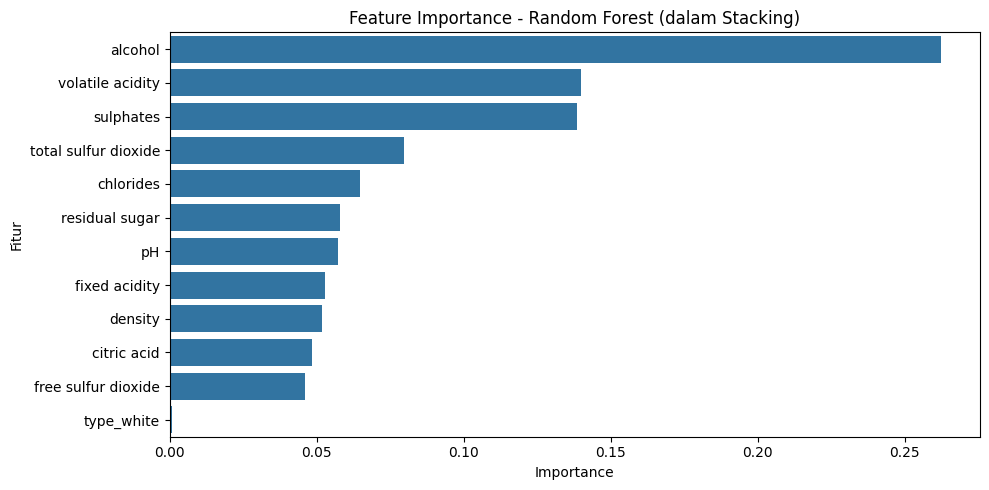

In [142]:
# Ambil feature importances dari salah satu base model (misalnya Random Forest)
base_model = model.named_estimators_['rf']  # 'rf' sesuai nama di stacking
importances = base_model.feature_importances_

features = X.columns
importance_df = pd.DataFrame({'Fitur': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisasi
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Fitur', data=importance_df)
plt.title(f'Feature Importance - Random Forest (dalam Stacking)')
plt.tight_layout()
plt.show()

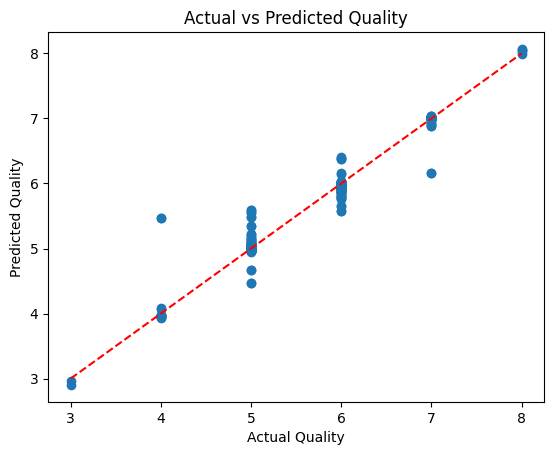

In [143]:
plt.scatter(y_test, y_pred) #Akurasi umum model secara visual
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs Predicted Quality")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Garis y = x
plt.show()


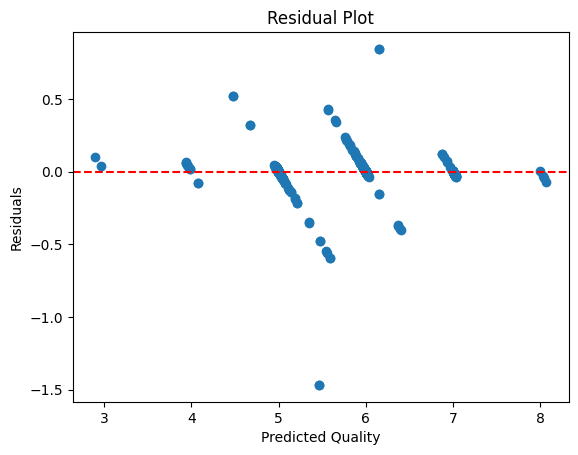

In [144]:
residuals = y_test - y_pred #	Melihat error dan bias model
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Quality")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


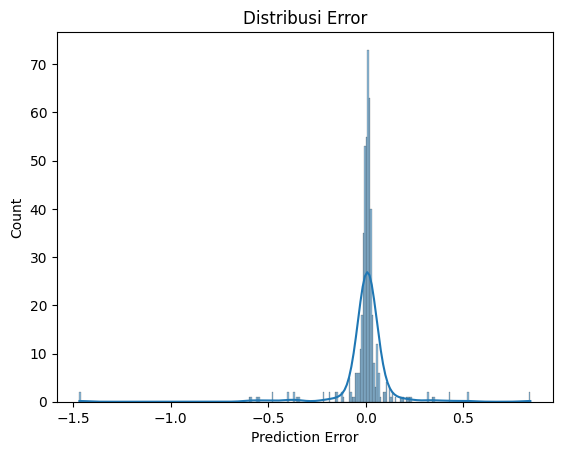

In [145]:
errors = y_test - y_pred #	Distribusi dan bentuk kesalahan prediksi
sns.histplot(errors, kde=True)
plt.xlabel("Prediction Error")
plt.title("Distribusi Error")
plt.show()
